# Исследование объявлений о продаже квартир

**Содержание** 
<a id=0> </a><br>
<br>
[Введение](#1)  <br>
[Предобработка данных](#2)  <br>
[Расчёты и добавление результатов в таблицу](#3)  <br>
[Исследовательский анализ данных](#4)<br>
[Вывод](#5)


## Введение
<a id=1> </a><br>

В нашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Задача — установить параметры, которые позволят определить рыночную стоимость объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. <br>
<br>
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd #импортируем библиотеку pandas
import math #импортируем библиотеку math
from datetime import datetime # импортируем модуль с датой и временем
import matplotlib.pyplot as plt # импортируем библиотеку для построения графиков
import numpy as np # импортируем библиотеку numpy
import seaborn as sns # импортируем библиотеку  seaborn для построения красивых графиков

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #прочтем датасет 
except FileNotFoundError:
    data = pd.read_csv('/Users/09e6y/Desktop/Катькис/Практикум/Проект 3 real estate/real_estate_dataset.csv', sep='\t')#посмотрим на данные

In [3]:
data.info()#соберем общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

У нас 22 колонки, примерно в половине из них встречаются пропуски. В колонках 'studio' и 'open_plan' содержатся булевы значения, тип данных в остальних колонках - целые, дробные числа, а так же текст - это названия населенного пункта и дата побликации. В колонке 'is_appartment' так же должен содержаться будев тип данных, но там пропуски и, возможно, какие-то ошибки - поэтому тип данных определяется как object.

In [4]:
data['first_day_exposition'].max()

'2019-05-03T00:00:00'

## Предобработка данных
<a id=2> </a><br>

Разберемся с пропусками

Пропуски в 'ceiling_height' кажется логичным заменить средним значением по данному населенному пункту. 

In [5]:
data_grouped = data.groupby('locality_name')['ceiling_height'].mean() #сгруппируем данные по населенному пункту и посчитаем среднее значение
data_grouped

locality_name
Бокситогорск            3.900000
Волосово                2.531579
Волхов                  3.151207
Всеволожск              2.675625
Выборг                  2.728776
                          ...   
село Путилово           2.550000
село Рождествено             NaN
село Русско-Высоцкое    2.580000
село Старая Ладога           NaN
село Шум                     NaN
Name: ceiling_height, Length: 364, dtype: float64

Какой интересный город Бокситогорск! Средняя высота потолков - 3,9м.<br>
<br>
Как видим, в некоторых населенных пунктах вообще нет таких данных - в этом случае, заменим пропуски просто на среднее. Мы выбрали среднее значение, а не медиану, потому что высота потолков не отличается так существенно, что это могло бы исказить данные

In [6]:
locality_name_unique = data['locality_name'].unique() #посмотрим на все уникальные значения интересующего нас столбца с населенными пунктами
display(locality_name_unique) #выведем значения на экран
len(locality_name_unique) #посчитаем количество уникальных значений

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

365

На этом этапе уже видны ошибки - некоторые названия населенных пунктов записаны через е и ё, можем сразу обработать эти данные.

In [7]:
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок') #заменим букву е на ё в слове "поселок"

In [8]:
locality_name_unique = data['locality_name'].unique() #посмотрим на все уникальные значения интересующего нас столбца с населенными пунктами
display(locality_name_unique) #выведем значения на экран
len(locality_name_unique) #посчитаем количество уникальных значений

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'посёлок Молодцово',
       'посёлок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'посёлок Торковичи', 'посёлок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет

331

Все поселки стали посёлками, а количество уникальных названий уменьшилось на 34!

In [9]:
data['ceiling_height'].isna().sum() # посчитаем количество пропусков в 'ceiling_height'

9195

Напишем цикл, который отсортирует данные по названию населенного пункта и затем вернет вместо пустого значения среднее по населенному пункту, если оно не пустое.

In [10]:
for city in data['locality_name'].unique():
    temp = data[data['locality_name'] == city]
    agg = temp['ceiling_height'].mean()
    data.loc[data['locality_name'] == city, 'ceiling_height'] = data['ceiling_height'].fillna(agg)
data['ceiling_height'] # выведем полученный результат на экран

0        2.700000
1        2.644470
2        2.803709
3        2.803709
4        3.030000
           ...   
23694    3.700000
23695    2.542286
23696         NaN
23697    3.000000
23698    2.500000
Name: ceiling_height, Length: 23699, dtype: float64

In [11]:
data['ceiling_height'].isna().sum() # проверим, сколько пропусков осталось

141

Т.к. для некоторых населенных пунктов вообще не было данных о высоте потолков - заменим такие данные на среднее значение по всему датасету.

In [12]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].mean())

In [13]:
data['ceiling_height'].isna().sum() # проверим, сколько пропусков осталось

0

Дальше обработаем пропуски в столбце 'floors_total'.

In [14]:
data['floors_total'].isna().sum() #посчитаем количество пропусков

86

Их совсем немного. Логичным будет взять информацию из столбца с этажом, на котором находится объект недвижимости - ведь в здании точно не может быть меньше этажей.

In [15]:
data[data['floors_total'].isna()]['floors_total'].fillna(data['floor'])

186       4.0
237       1.0
457      12.0
671       8.0
1757      9.0
         ... 
22542     3.0
22656    20.0
22808     6.0
23590    18.0
23658     8.0
Name: floors_total, Length: 86, dtype: float64

In [16]:
def floor_defineder(wtfloor): #напишем функцию, которая в зависимости от того, содержится ли пропуск в колонке 'floors_total'
    floors_total = wtfloor['floors_total'] #возвращает значение из колонки 'floor', либо сохраняет свое значение
    floor = wtfloor['floor']
    if math.isnan(floors_total):
        return floor
    else:
        return floors_total
data['floors_total'] = data.apply(floor_defineder, axis=1) #применим функцию к датафрейму методом apply

In [17]:
data['floors_total'].isna().sum() #проверим, не осталось ли пропусков

0

Теперь разберемся в пропусках в столбце 'is_apartment'. Скорее всего, если данные не указаны - это не аппартаменты, поэтому будет уместным заменить пропуски на значение False.

In [18]:
data['is_apartment'] = data['is_apartment'].fillna(False)

В столбце 'balcony' тоже содержится булев тип данных, поступим с пропусками в нем так же как и с пропусками в столбце 'is_apartment.

In [19]:
data['balcony'] = data['balcony'].fillna(False)

Займемся пропусками в столбце с расстоянием до ближайшего аэропорта. Для начала возьмем данные из тех же населенных пунктов, если такие данные есть в датасете.

In [20]:
data['airports_nearest'].isna().sum() #посчитаем количество пропусков

5542

In [21]:
data['airports_nearest_isna'] = data['airports_nearest'].isna().astype(int) # превратим булев тип - в числа 
df = data.groupby('locality_name')['airports_nearest_isna'].agg(['sum', 'count']) # выполним группировку по населенным пунктам, посчитаем данные и пропуски в них 
display(df.shape[0]) # сколько всего городов в данных
df[df['sum'] == df['count']]

330

,sum,count
locality_name,,
Бокситогорск,16,16
Волосово,36,36
Волхов,111,111
Всеволожск,398,398
Выборг,237,237
...,...,...
село Путилово,2,2
село Рождествено,3,3
село Русско-Высоцкое,9,9


У ас 330 населенных пунктов 303 из них - с пропусками в данных о ближайшем аэропорте - это очень много, мы не можем избавиться от этих пропусков, не исказив при этом данные. Поэтому оставим как есть. 

Теперь поработаем с пропусками в столбцах 'parks_around3000'(число парков в пределах 3 км) и 'parks_nearest' (расстояние до ближайшего парка в метрах).

In [22]:
data['parks_around3000'].isna().sum() #посчитаем количество пропусков

5518

In [23]:
data['parks_nearest'].isna().sum() #посчитаем количество пропусков

15620

Будем считать, что если в пределах 3 км от объекта недвижимости находится парк - мы можем добавить расстояние 3 км до парка в колонку 'parks_nearest'. Пропусков очень много, если посчитать среднее или медианное расстояние до парка и заполнить им пропуски - данные могут оказаться слишком не точными, потому что среднее и медианное - меньше 500 м. Если бы парк действительно находился бы так близко - данные об этом обязательно бы добавили в датасет.

In [24]:
def parks(isit_park): #напишем функцию, которая будет проверять наличие данных в колонке 'park_nearest' и заполнять их
    parks_around3000 = isit_park['parks_around3000'] #в случае если в колонке 'parks_around3000' содержатся значения отличные от 0
    parks_nearest = isit_park['parks_nearest']
    if parks_around3000!=0 and math.isnan(parks_nearest):
        return 3000
    else:
        return parks_nearest
data['parks_nearest'] = data.apply(parks, axis=1) #применим функцию к интересующей нас колонке мотодом apply

In [25]:
data['parks_nearest'].isna().sum()

10102

Пропусков стало меньше! 

Поступим таким же образом с водоёмами.

In [26]:
data['ponds_around3000'].isna().sum() #посчитаем количество пропусков 

5518

In [27]:
data['ponds_nearest'].isna().sum() #посчитаем количество пропусков 

14589

In [28]:
def ponds(isit_pond): #напишем функцию
    ponds_around3000 = isit_pond['ponds_around3000'] 
    ponds_nearest = isit_pond['ponds_nearest']
    if ponds_around3000!=0 and math.isnan(ponds_nearest):
        return 3000
    return ponds_nearest
data['ponds_nearest'] = data.apply(ponds, axis=1) #применим функцию к интересующей нас колонке мотодом apply

In [29]:
data['ponds_nearest'].isna().sum() #проверим, правильно ли сработала функция

9071

Все получилось, пропусков стало меньше на 5,5 тысяч.

Далее обработаем пропуски в столбце 'days_exposition'. Воспользуемся для этого данными из столбца 'first_day_exposition'. Предположим, пропуски в объявлениях, которые еще не закрыты.

In [30]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
# преобразуем формат в колонке с первым днем экспозиции

In [31]:
def days(wtday): # напишем функцию, которая будет считать количество дней экспозиции, в зависимости от того, когда было выставлено объявление
    first_day_exposition = wtday['first_day_exposition']
    days_exposition = wtday['days_exposition']
    if math.isnan(days_exposition):
        return (datetime.now() - first_day_exposition).days
    else:
        return days_exposition
data['days_exposition'] = data.apply(days, axis=1) # применим функцию к датасету
data['days_exposition'].isna().sum() # проверим, не осталось ли пропусков

0

Мы обработали бОльшую часть пропусков, оставшиеся - не должны помешать нам провести исследование. А в попытках избавиться от всех пропусков мы можем слишком сильно исказить данные.

[Содержание](#0)

## Расчёты и добавление результатов в таблицу
<a id=3> </a><br>

Когда мы завершили предобработку данных, можем перейти к расчётам.<br>
<br>
Для начала посчитаем цену за квадратный метр недвижимости, добавим соответствующую колонку в датасет.

In [32]:
data['price_m2'] = data['last_price']/ data['total_area'] #посчитаем цену за квадратный метр, поделив цену объекта на общую площадь
data['price_m2'] = data['price_m2'].round(1) #оставим 1 знак после запятой
data.head(10)#выведем на экран первые 10 строк

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,airports_nearest_isna,price_m2
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16.0,51.00,8,False,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,1357.0,0,120370.4
1,7,3350000.0,40.40,2018-12-04,1,2.644470,11.0,18.60,1,False,...,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0,82920.8
2,10,5196000.0,56.00,2015-08-20,2,2.803709,5.0,34.30,4,False,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0,92785.7
3,0,64900000.0,159.00,2015-07-24,3,2.803709,14.0,NaN,9,False,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,0,408176.1
4,2,10000000.0,100.00,2018-06-19,2,3.030000,14.0,32.00,13,False,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0,100000.0
5,10,2890000.0,30.40,2018-09-10,1,2.632759,12.0,14.40,5,False,...,городской посёлок Янино-1,NaN,NaN,NaN,3000.0,NaN,3000.0,55.0,1,95065.8
6,6,3700000.0,37.30,2017-11-02,1,2.630292,26.0,10.60,6,False,...,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,0,99195.7
7,5,7915000.0,71.60,2019-04-18,2,2.803709,24.0,NaN,22,False,...,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,1315.0,0,110544.7
8,20,2900000.0,33.16,2018-05-23,1,2.922383,27.0,15.43,26,False,...,посёлок Мурино,NaN,NaN,NaN,3000.0,NaN,3000.0,189.0,1,87454.8
9,18,5400000.0,61.00,2017-02-26,3,2.500000,9.0,43.60,7,False,...,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,0,88524.6


Извлечем из колонки с датой и добавим в таблицу отдельными колонками день недели, месяц и год публикации объявления.

Выше мы уже поменяли тип данных в 'first_day_exposition' на datetime.

In [33]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['weekday'] # проверим результат

0        3
1        1
2        3
3        4
4        1
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: weekday, Length: 23699, dtype: int64

Добравим в датасет месяц и год.

In [34]:
data['month'] = data['first_day_exposition'].dt.month # добавим в датасет колонку с месяцем

In [35]:
data['year'] = data['first_day_exposition'].dt.year # добавим год

Воспользуемся информацией из столбца 'floor' чтобы дополнить датасет информацией, является ли этаж первым, последним или другим.

In [36]:
def f_groupes(row): # напишем функцию
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'другой'
data['floor_groupes'] = data.apply(f_groupes, axis=1) # применим функцию к датасету
data['floor_groupes'] # проверим работу функции

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23694    другой
23695    другой
23696    первый
23697    другой
23698    первый
Name: floor_groupes, Length: 23699, dtype: object

Вычислим соотношение жилой и общей площади.

In [37]:
data['living_ratio'] = data['living_area']/data['total_area'] # разделим жилую площадь на общую, чтобы узнать соотношение
data['living_ratio'] # выведем результат на экран

0        0.472222
1        0.460396
2        0.612500
3             NaN
4        0.320000
           ...   
23694    0.547792
23695    0.644068
23696    0.523810
23697         NaN
23698    0.380805
Name: living_ratio, Length: 23699, dtype: float64

Так же вычислим отношение площади кухни к общей.

In [38]:
data['kitchen_ratio'] = data['kitchen_area']/data['total_area'] # разделим площадь  кухни на общую, чтобы узнать соотношение
data['kitchen_ratio'] # выведем результат на экран

0        0.231481
1        0.272277
2        0.148214
3             NaN
4        0.410000
           ...   
23694    0.103356
23695    0.144068
23696         NaN
23697    0.303583
23698    0.278638
Name: kitchen_ratio, Length: 23699, dtype: float64

[Содержание](#0)

## Исследовательский анализ данных
<a id=4> </a><br>

### Визуализация данных 

Перейдем непосредственно к анализу предоставленных данных. Для начала изучим следующие параметры: площадь, цену, число комнат, высоту потолков. Пострим графики для каждого параметра.<br>


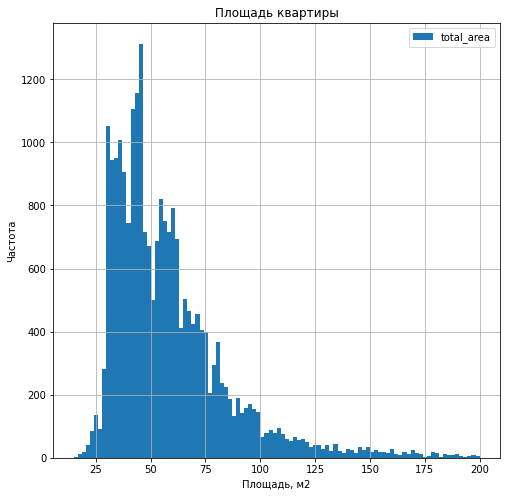

In [39]:
data.plot(kind='hist',
          y='total_area',
          range=(15, 200),
          bins=100,
          grid=True,
          legend=True,
          figsize=(8,8))
plt.title('Площадь квартиры')
plt.ylabel('Частота')
plt.xlabel('Площадь, м2');

Хорошо видно, что большая часть объектов находится в диапазоне от 25 до 75 м2, но элитная недвижимость тоже имеет право на существование, поэтому сделаем срез от 25 до 150м2, а хвосты отбросим.

Теперь посмотрим на цену квартиры. Для начала посмотрим минимальное и максимальное значение, чтобы построить гистограмму.

In [40]:
data['last_price'].min()

12190.0

In [41]:
data['last_price'].max()

763000000.0

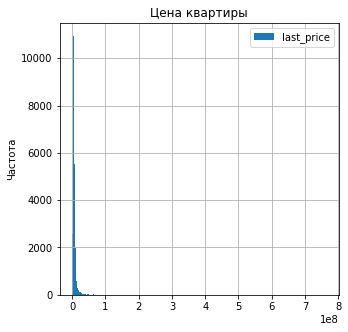

In [42]:
data.plot(kind='hist',
          y='last_price',
          range=(12190, 763000000),
          bins=300,
          grid=True,
          legend=True,
          figsize=(5,5))
plt.title('Цена квартиры')
plt.ylabel('Частота')
plt.show()

Такая гистограмма абсолютно ненаглядна. Очевидно, что значение в 700 миллионов очень сильно завышено, да и цена в 12190 выглядит не очень правдоподобно, возможно это аренда а не стоимость объекта, поэтому отбросим хвосты, как мы делали с предыдущим значением, чтобы разглядеть на графике хоть что-то.

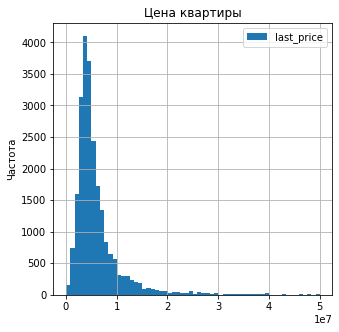

In [43]:
data.plot(kind='hist',
          y='last_price',
          range=(30000, 50000000), # оставим диапазон значений от 30 тысяч до 50 миллионов
          bins=60,
          grid=True,
          legend=True,
          figsize=(5,5))
plt.title('Цена квартиры')
plt.ylabel('Частота')
plt.show()

Проверим, как много данных мы отбросили.

In [44]:
len(data.query('last_price<30000 or last_price>50000000')) # посчитаем количество значений в срезе, которые мы отбросили

132

Всего 132 значения - смело можем от них избавиться.

In [45]:
data = data.query('last_price>30000 or last_price<50000000')

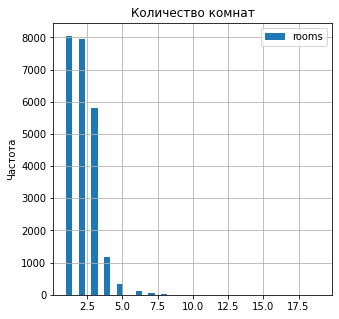

In [46]:
data.plot(kind='hist',
          y='rooms',
          range=(1, 19),
          bins=40,
          grid=True,
          legend=True,
          figsize=(5,5))
plt.title('Количество комнат')
plt.ylabel('Частота')
plt.show()

Из графика видно, что большинство квартир имеет от 1 до 5 комнат, поэтому целесообразно отсечь хвост с аномальным количеством комнат. Например, можно посмотреть, сколько объектов имеют по 19 и 16 комнат.

In [47]:
len(data.query('rooms==19')) # посчитаем количество значений в срезе данных по количеству комнат = 19

1

In [48]:
len(data.query('rooms==16')) # посчитаем количество значений в срезе данных по количеству комнат = 16

1

Скорее всего это вброс и такие значения мы можем отбросить.

In [49]:
display(len(data.query('rooms>5'))) # посчитаем количество объектов недвижимости с количеством комнат больше 5
len(data.query('rooms>5'))/len(data['rooms'])

195

0.008228195282501372

Меньше 1% объектов недвижимости имеют больше 5 комнат - можем не брать их во внимание в дальнейшем исследовании. 

In [50]:
data = data.query('rooms<5')

Построим гистограмму для высоты потолков.

In [51]:
data['ceiling_height'].min() # минимальное значение

1.0

In [52]:
data['ceiling_height'].max() # максимальное значение

100.0

Значения минимума и максимума явно являются выбросами.

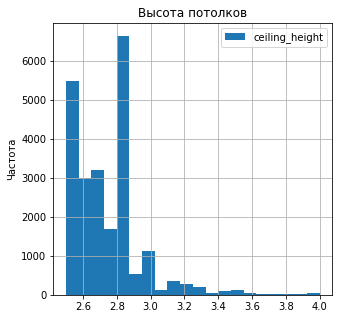

In [53]:
data.plot(kind='hist',
          y='ceiling_height',
          range=(2.5, 4),
          bins=20,
          grid=True,
          legend=True,
          figsize=(5,5))
plt.title('Высота потолков')
plt.ylabel('Частота')
plt.show()

Хорошо видна типовая российская застройка - больше всего квартир с высотой потолков в диапазоне от 2,6 до 2,8м. Но отбросив все потолки 3 м мы удалим всю элитную недвижимость центра Петербурга, а нам бы не хотелось обижать культурную столицу, даже если таких квартир немного.

In [54]:
data = data.query('ceiling_height<4 or ceiling_height >3.6')

### Расчёт времени продажи

Изучим данные о продажах квартир - узнаем среднее и медианное значения. И хотя мы не можем точно сказать, что объявление было снять после закрытия сделки - но других данных у нас нет, поэтому примем количество дней экспозиции за количество дней от размещения до продажи объекта.

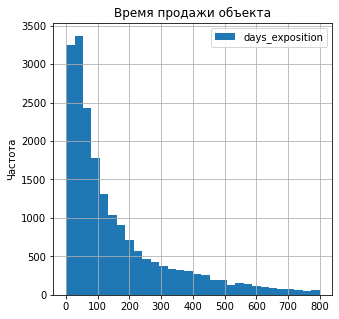

In [55]:
data.plot(kind='hist',
          y='days_exposition',
          range=(1, 800),
          bins=30,
          grid=True,
          legend=True,
          figsize=(5,5))
plt.title('Время продажи объекта')
plt.ylabel('Частота')
plt.show()

Как видно из гистограммы - большая часть квартир продается в течение полугода. Эти данные выглядят правдоподобными. Но нужно разобраться с экстремальными значениями. 

In [56]:
data['days_exposition'].describe() # посмотрим на данные в столбце с экспозицией подробно 

count    23178.000000
mean       354.130771
std        506.183731
min          1.000000
25%         45.000000
50%        122.000000
75%        382.000000
max       2918.000000
Name: days_exposition, dtype: float64

In [57]:
np.percentile(data['days_exposition'], 95) # найдем границу 5% максимально длительных продаж

1465.0

Наличие в датасете экстремально высоких значений сильно завышает среднее. Мы считаем, будет уместно отбросить значения больше 3,5 лет как выброс. Это соответствует верхним 5% данных датасета. Экстремально низкими будем считать значения меньше недели.

Рассмотрим данные чуть подробнее.

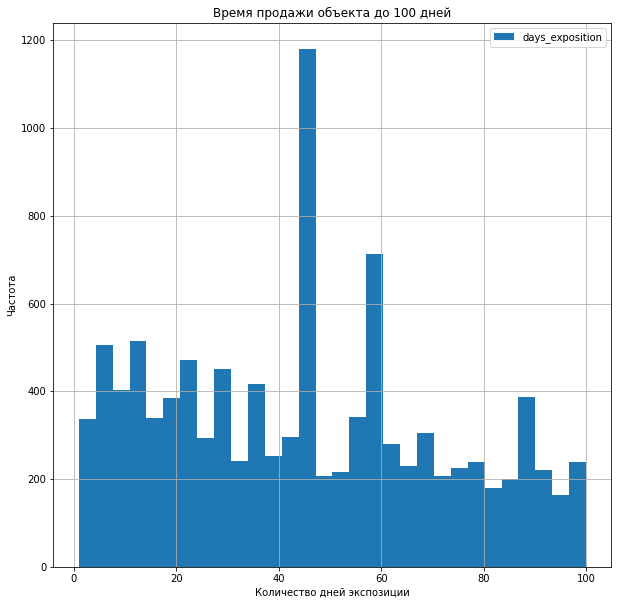

In [58]:
data.plot(kind='hist',
          y='days_exposition',
          range=(1, 100),
          bins=30,
          grid=True,
          legend=True,
          figsize=(10,10))
plt.title('Время продажи объекта до 100 дней')
plt.ylabel('Частота')
plt.xlabel('Количество дней экспозиции')
plt.show()

Видны выбросы в районе 45,60 и 90 дней. В эти дни портал удаляет с показа бесплатные объявления.

Теперь отбросим наши хвосты и построим новую гистограмму.

In [59]:
display(data['days_exposition'].min()) # узнаем минимальное количество дней экспозиции
len(data.query('days_exposition < 7')) # посчитаем, часто ли бывает что квартира продается за неделю

1.0

611

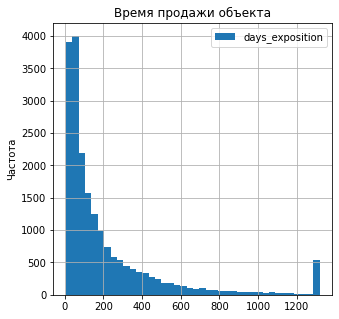

In [60]:
data.plot(kind='hist',
          y='days_exposition',
          range=(7, 1320),
          bins=40,
          grid=True,
          legend=True,
          figsize=(5,5))
plt.title('Время продажи объекта')
plt.ylabel('Частота')
plt.show()

Интересно, что на 4 году продажи появляется всплеск, есть предположение, что это искажение данных, связанное с тем как мы обработали пропуски в стобце 'days_exposition'.

### Влияние различных факторов на стоимость квартиры

Посмотрим, какие факторы больше всего влияют на стоимость квартиры. В этом нам помогут диаграммы рассеяния - они покажут, коррелирует ли цена квартиры с разными данными из нашего датасета. Следует сразу сказать, что не очень корректно сравнивать цены по всему датасету - т.к. больше всего на цену будет влиять, находится ли объект в крупном городе или в деревне.

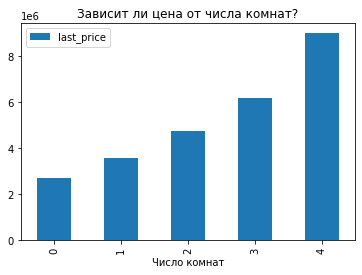

In [61]:
data.groupby('rooms').median().reset_index().plot(kind='bar', x='rooms', y='last_price')
plt.title('Зависит ли цена от числа комнат?')
plt.xlabel('Число комнат')
plt.show()

Ценовой диапазон явно зависит от количества комнат, но мы не видим прямой зависимости, потому что в выборку попали квартиры и в Спб и в окрестностях.

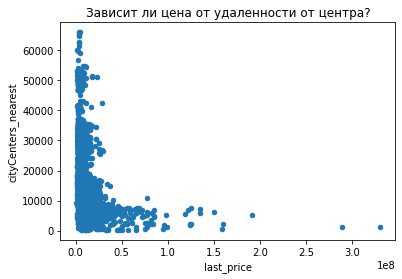

In [62]:
data.plot(x='last_price', y='cityCenters_nearest', kind='scatter')
plt.title('Зависит ли цена от удаленности от центра?')
plt.show()

Квартиры в центре чаще всего стоят дороже - что логично.

Посмотрим, существует ли корреляция между ценой квартиры и этажом. Для этого хорошо подойдет столбчатая диаграма. 

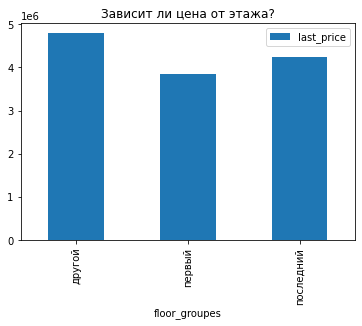

In [63]:
data.groupby('floor_groupes').median().reset_index().plot(kind='bar', x='floor_groupes', y='last_price')
# сделаем группировку по этажу и построим диаграмму по медиане
plt.title('Зависит ли цена от этажа?')
plt.show()

Видно, что самые дорогие квартиры - не на первом этаже, вообще можно сделать вывод, что на первом этаже квариры дешевле, а на всех остальных - этаж не сильно влияет на стоимость квартиры. Возможно это потому, что никто не любит решетки на окнах и шум мусоровоза ночью. 

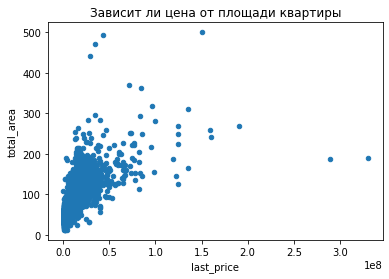

In [64]:
data.plot(x='last_price', y='total_area', kind='scatter') # построим диаграмму рассеяния
plt.title('Зависит ли цена от площади квартиры')
plt.show()

А вот от площади квартиры цена зависит напрямую. Можем проверить это на цифрах при помощи коэффициента корреляции Пирсона.

In [65]:
data['last_price'].corr(data['total_area']) # посчитаем коэффициент корреляции

0.6707560660462315

Изучим, насколько время размещения влияет на цену.

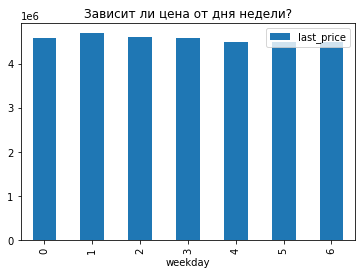

In [66]:
data.groupby('weekday').median().reset_index().plot(kind='bar', x='weekday', y='last_price')
# сделаем группировку по этажу и построим диаграмму по медиане
plt.title('Зависит ли цена от дня недели?')
plt.show()

Особой корреляции мы не видим.

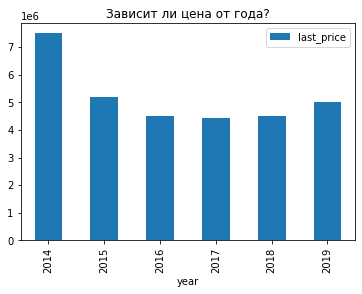

In [67]:
data.groupby('year').median().reset_index().plot(kind='bar', x='year', y='last_price')
# сделаем группировку по этажу и построим диаграмму по медиане
plt.title('Зависит ли цена от года?')
plt.show()

Видим, что максимальные цены на жилье были в 2014. Возможно, это связано с Олимпиадой. Но у нас нет данных за более ранний период, так что возможно просто после 2014 цены упали в связи с некоторыми экономическими процессами в стране. Интересно было бы посмотреть на более свежие данные.

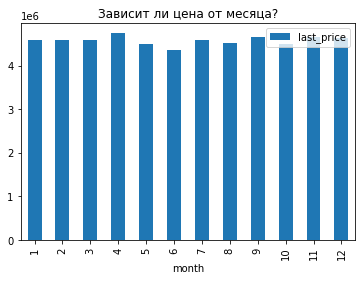

In [68]:
data.groupby('month').median().reset_index().plot(kind='bar', x='month', y='last_price')
# сделаем группировку по этажу и построим диаграмму по медиане
plt.title('Зависит ли цена от месяца?')
plt.show()

И здесь тоже - нет. Квартиры продаются за примерно ту же цену, независимо от времени года - ведь людям всегда нужно где-то жить. Разве что есть небльшая просадка в июне - низкий сезон, все в отпусках, стоимость жилья немного падает. Возможно, если вы хотите срочно продать квартиру - лучше делать это не летом.

Так же дополнительно посмотрим, зависит ли цена квартиры от площади кухни.

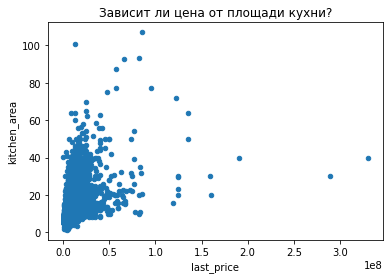

In [69]:
data.plot(x='last_price', y='kitchen_area', kind='scatter') # построим диаграмму рассеяния
plt.title('Зависит ли цена от площади кухни?')
plt.show()

Зависимость есть - но скорее всего, она опосредованная, так как чем больше площадь жилья - тем больше площадь кухни.

### Топ-10 городов с наибольшей и наименьшей стоимостью жилья

Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем для них среднюю цену квадратного метра.

In[68]:

In [70]:
top_10 = data.pivot_table(index='locality_name', values='price_m2', aggfunc=('count','mean')).round(0)
#построим сводную таблицу с количеством объявлений и средней ценой
top_10 = top_10.sort_values(by='mean', ascending=False).head(10) 
top_10 # выведем топ-10 населенных пунктов

,count,mean
locality_name,,
Зеленогорск,24,115123.0
Санкт-Петербург,15244,114011.0
посёлок Репино,4,104239.0
Пушкин,363,103061.0
Сестрорецк,181,102232.0
посёлок Лисий Нос,3,100661.0
Кудрово,173,100253.0
деревня Мистолово,11,98550.0
посёлок Левашово,1,96998.0


In [71]:
top_10 = top_10.reset_index() # сделаем так, чтобы населенные пункты перестали быть индексами

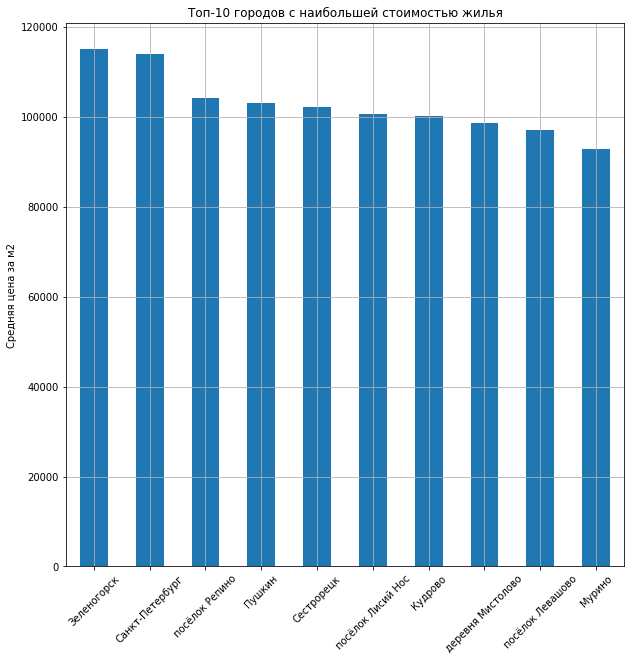

In [72]:
top_10.plot( # построим столбчатую диаграмму
    kind='bar',
    x='locality_name',
    xlabel = '',
    y='mean',
    ylabel='Средняя цена за м2',
    rot=45,
    grid=True,
    legend=False,
    figsize=(10,10)
    );
plt.title('Топ-10 городов с наибольшей стоимостью жилья')
plt.show()

Из нашего топа объявлений самые дорогие квартиры - в Зеленогорске, а самые дешевые - в печально знаменитом Мурино.

### Как изменится цена при удалении от центра города?

Разберемся, как меняется цена на жилье при удалении от центра города. Возьмем Санкт_Петербург - он в нашем топе городов с количеством объявлений (как и цены на жилье), поэтому данные по нему будут являться достаточно репрезентативными.

In [73]:
data.loc[data['locality_name'] == "Санкт-Петербург", 'center_km'] = data[data['locality_name'] == "Санкт-Петербург"]['cityCenters_nearest'] / 1000
data.head # добавим колонку с расстоянием до цента Петербурга 
data['center_km'] = data['center_km'].round(0) # округлим до целого
spb = data.query('locality_name == "Санкт-Петербург"')
spb_center_price = spb.pivot_table(index='center_km', values='last_price', aggfunc='median').reset_index().sort_values(by='center_km')
# заполним сводную таблицу медианным значением

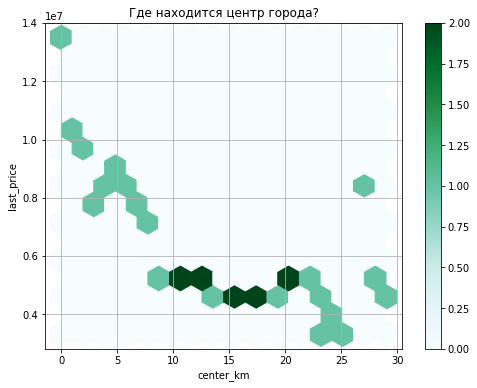

In [74]:
spb_center_price.plot(x='center_km', y='last_price', kind='hexbin', gridsize=15, figsize=(8, 6), sharex=False, grid=True) 
plt.title('Где находится центр города?')
plt.show()

In [75]:
spb_center_price['center_km'].corr(spb_center_price['last_price'])

-0.7333794920446298

Есть выраженная обратная корреляция - чем больше расстояние от центра - тем ниже цена. Видно перепад цены на 5 и 10 км, будем считать 6 км - пределами центра города, так как после этой отметки цена резко падает. Эту цифру можно обосновать, посмотрев на данные более детально.

In [76]:
spb_center_price.groupby('center_km')['last_price'].sum().head(15)

center_km
0.0     13500000.0
1.0     10050000.0
2.0      9325000.0
3.0      8000000.0
4.0      8500000.0
5.0      8900000.0
6.0      8342500.0
7.0      7600000.0
8.0      7350000.0
9.0      5290000.0
10.0     5000000.0
11.0     5000000.0
12.0     4950000.0
13.0     5200000.0
14.0     4848500.0
Name: last_price, dtype: float64

Мы видим, что после отметки в 6 км цена существенно падает.

### Исследование квартир в центре города

Выделим сегмент квартир в центре.

Проанализируем данные по той же схеме, что мы проделали со всей выборкой - и сравним их.

In [77]:
spb_center = spb.query('center_km<6') # отфильтруем данные по расстоянию до центра
spb_center_df = spb_center.pivot_table(index='last_price', values=['center_km', 'price_m2', 'total_area', 'rooms', 'ceiling_height'], aggfunc='median').reset_index()
spb_center_df

,last_price,ceiling_height,center_km,price_m2,rooms,total_area
0,1600000.0,3.000000,4.0,17391.3,3.0,92.0
1,1686000.0,2.803709,4.0,127727.3,1.0,13.2
2,1850000.0,3.400000,5.0,142307.7,1.0,13.0
3,2100000.0,2.803709,3.5,78750.0,2.0,48.0
4,2176000.0,2.900000,4.0,94608.7,0.0,23.0
...,...,...,...,...,...,...
751,159000000.0,2.803709,0.0,611538.5,4.0,260.0
752,159984000.0,3.850000,2.0,660000.0,4.0,242.4
753,190870000.0,2.803709,5.0,712201.5,3.0,268.0
754,289238400.0,3.370000,1.0,1542604.8,2.0,187.5


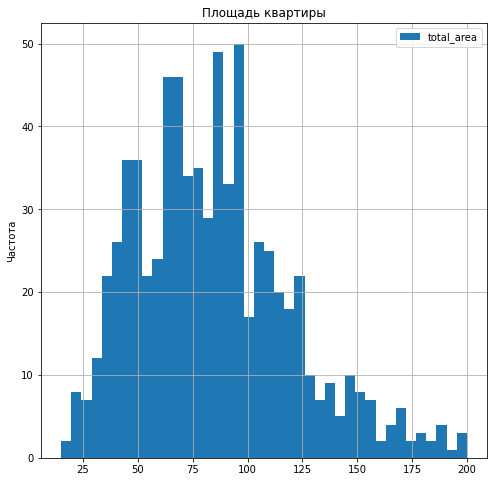

In [78]:
spb_center_df.plot(kind='hist', # построим график
          y='total_area', # название столбца с анализируемыми данными
          range=(15, 200), # разброс значений
          bins=40,
          grid=True,
          legend=True,
          figsize=(8,8))
plt.title('Площадь квартиры') # заголовок 
plt.ylabel('Частота')
plt.show() # скороем надпись, чтоб было красиво

В центре Петербурга - больший разброс по площади квартир, здесь и квартиры с площадью в 100м2 - не редкость, но известно, что это в, основном, коммуналки. Это хорошо видно на диаграмме boxplot. 

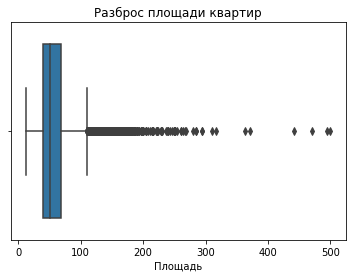

In [79]:
sns.boxplot(x= data['total_area']) # при помощи библиотеки seaborn построим диаграмму boxplot
plt.title('Разброс площади квартир')
plt.xlabel('Площадь')
plt.show()

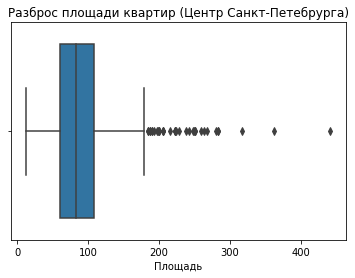

In [80]:
sns.boxplot(x= spb_center_df['total_area'])
plt.title('Разброс площади квартир (Центр Санкт-Петебрурга)')
plt.xlabel('Площадь')
plt.show()

Посчитаем среднюю цену за м2, для удобства округлим ее до целых чисел

In [81]:
display(int(data['price_m2'].mean())) # средняя цена квартиры по всей выборке
display(int(spb['price_m2'].mean())) # средняя цена квартиры с СПб
int(spb_center_df['price_m2'].mean()) # средняя цена квартиры в центре СПб

98622

114010

161582

Полученные данные довольно репрезентативны - квартиры в Санкт-Петербурге в среднем дороже чем по региону, а квартиры в центре - дороже всего, что логично и правдоподобно.

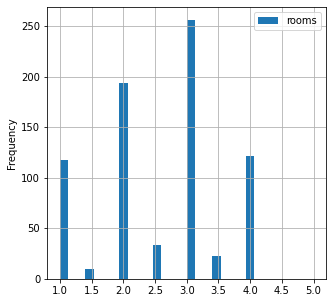

In [82]:
spb_center_df.plot(kind='hist',
          y='rooms',
          range=(1, 5),
          bins=30,
          grid=True,
          legend=True,
          figsize=(5,5))
plt.title('Количество комнат')
plt.title('')
plt.xlabel('')
plt.show()

Данные немного отличаются от всей выборки - раньше больше всего было квартир с 1 и 2 комнатами, а в центре Санкт-Петербурга больше всего 3-комнатных квартир.

Проанализируем высоту потолков в центре Петербурга и сравним ее со всей выборкой.

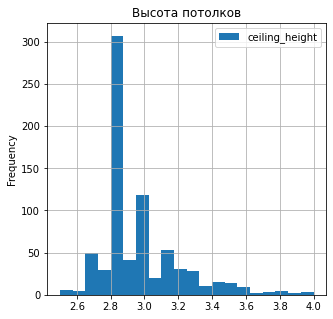

In [83]:
spb_center_df.plot(kind='hist',
          y='ceiling_height',
          range=(2.5, 4),
          bins=20,
          grid=True,
          legend=True,
          figsize=(5,5))
plt.title('Высота потолков')
plt.show()

Все те же типовые 2,8 метра.

Посмотрим на то как данные в новом датасете коррелируют между собой. Для удобства построим диаграмму рассеяния по всей сводной таблице центра Санкт-Петербурга сразу, и будем сравнивать данные попарно.

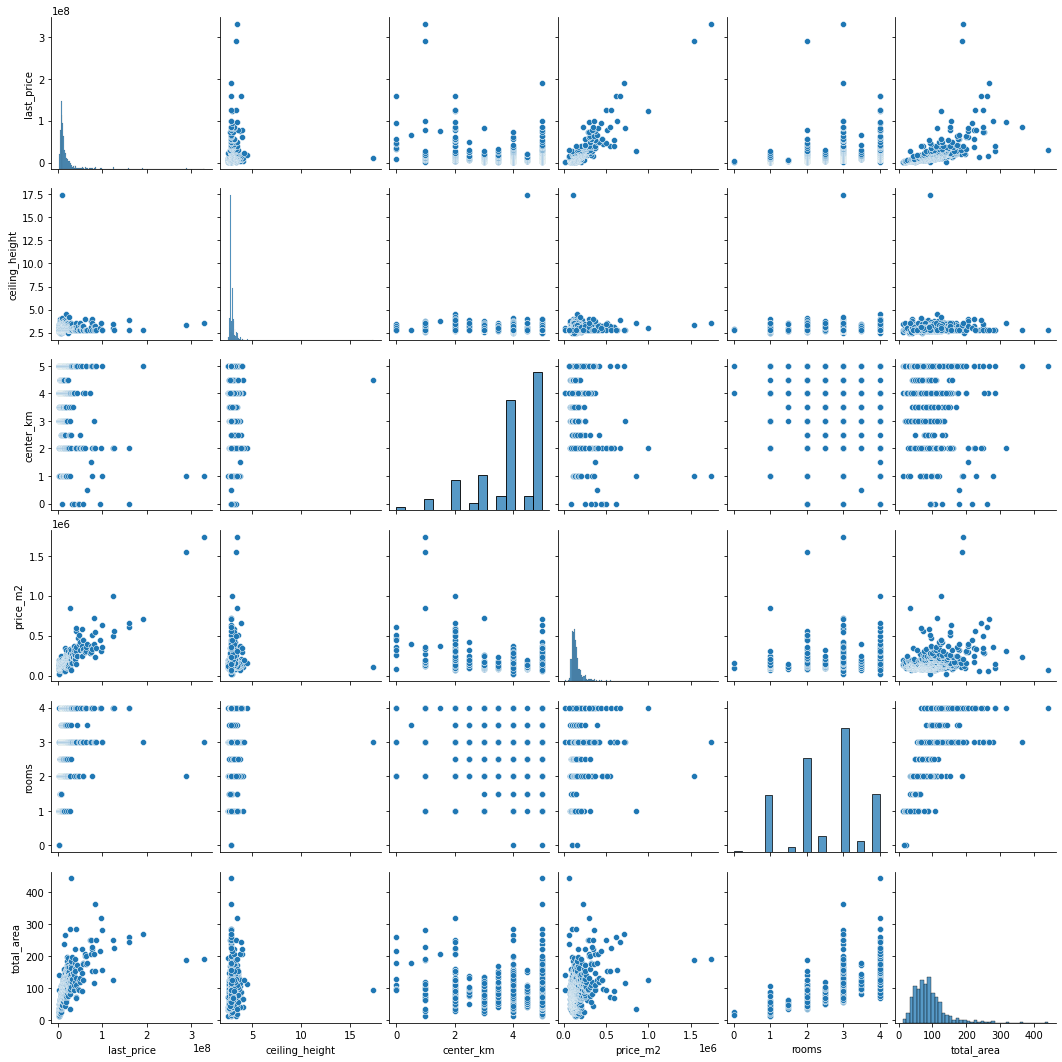

In [84]:
sns.pairplot(spb_center_df)
plt.show()

Дополнительно посмотрим корреляцию с близостью водоема и парков.

In [85]:
spb_center_nature = spb_center.pivot_table(index='price_m2', values=['parks_nearest', 'ponds_nearest'], aggfunc='median').reset_index()
# построим сводную таблицу по данным о близости парка или водоема 
display(spb_center_nature['price_m2'].corr(spb_center_nature['parks_nearest']))
spb_center_nature['price_m2'].corr(spb_center_nature['ponds_nearest']) # посчитаем коэффициент корреляции

0.0045071649814190685

-0.06573337658221585

Видим +- те же зависимости что и в основном датасете:<br>
1. больше всего на цену влияет площадь квартиры;<br>
2. общая цена коррелирует с ценой за м2;<br>
3. чем больше комнат - тем больше может быть цена за квартиру;<br>
4. корреляция с удаленностью от центра тут не очень просматривается - потому что мы и так сделали выборку квартир в центре8;<br>
5. высота потолков не сильно влияет на цену квартиры;<br>
6. корреляция с близостью парков и водоемов настолько незначительная - что ею явно можно пренебречь.<br>


Дополнительно хотелось бы проверить один параметр. Как именно влияет размер кухни на стоимость жилья, только теперь мы будем смотреть на стоимость за м2 - чтобы не получить искажение данных как в первом случае, когда мы проверяли, влияет ли размер кухни на стоимость целого объекта недвижимости.

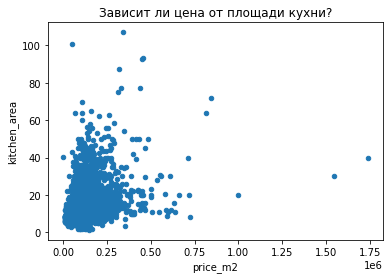

In [86]:
data.plot(x='price_m2', y='kitchen_area', kind='scatter') # построим диаграмму рассеяния
plt.title('Зависит ли цена от площади кухни?')
plt.show()

И такая зависимость есть! Цена квартиры действительно зависит от размера кухни. 

Сравним так же данные, показывающие зависимость от дня, месяца и года.

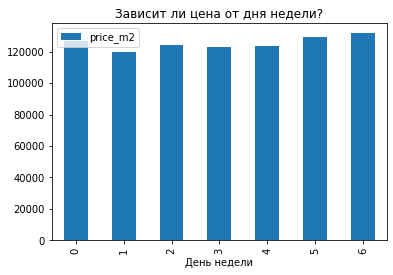

In [87]:
spb_center.groupby('weekday').median().reset_index().plot(kind='bar', x='weekday', y='price_m2')
# сделаем группировку по этажу и построим диаграмму по медиане
plt.title('Зависит ли цена от дня недели?')
plt.xlabel('День недели')
plt.show()

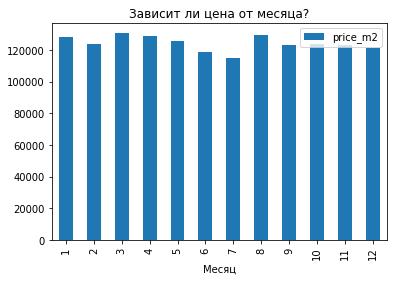

In [88]:
spb_center.groupby('month').median().reset_index().plot(kind='bar', x='month', y='price_m2')
# сделаем группировку по этажу и построим диаграмму по медиане
plt.title('Зависит ли цена от месяца?')
plt.xlabel('Месяц')
plt.show()

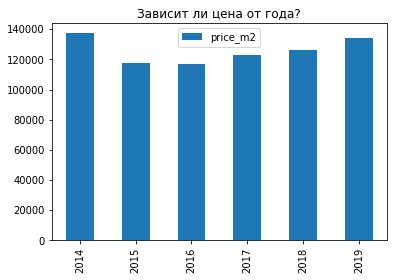

In [89]:
spb_center.groupby('year').median().reset_index().plot(kind='bar', x='year', y='price_m2')
# сделаем группировку по этажу и построим диаграмму по медиане
plt.title('Зависит ли цена от года?')
plt.xlabel('')
plt.show()

Похоже, данные по центру Санкт-Петербурга не сильно отличаются от общих данных по региону:<br>
1. наблюдается та же небольшая просадка в летние месяцы;<br>
2. после 2014 падение цен;<br>
3. есть небольшая особенность - судя по графику, квартиры выставленные в выходные и понедельник продавались по более высокой цене (риэлтору на заметку).

[Содержание](#0)

## Общий вывод
<a id=5> </a><br>

Мы проанализировали данные о продаже кварир в Петербурге и окрестностях с 2014 по 2019 годы, выявили аномалии и выбросы в данных, провели исследование по разным параметрам. <br>
Для начала, хотелось бы обратить внимание на многочисленные пропуски в данных. Часть данных была добавлена автоматически при помощи алгоритма - в этих данных пропусков оказалось больше всего и их почти не возможно успешно обработать. Речь идет о расстоянии до ближайшего аэропорта, парков и водоемов - возможно разработчики могли бы доработать эту систему и получить более полные данные.<br>
Так же в данных были аномальные значения - потолки высотой 100 м и 1 м и квартиры, которые продавались по 8 лет, а так же помещения с 19 и 16 комнатами. Таких выбросов не так много и мы смогли обработать их так что это не повлияло на конечный результат исследования. <br>
Мы получили данные о следующих факторах, влияющих на рыночную стоимость квартиры, большинство из них ожидаемы.<br>
1. Метраж - чем больше площадь квартиры, тем выше ее цена.<br>
2. Количество комнат - чем больше комнат - тем выше цена.<br>
3. Близость к центру города (если речь идет о крупном городе, как Санкт_Петербург) так же повышает стоимость квартиры.<br>
4. Этаж - на первом этаже цена квартир ниже.<br>
Но есть и неожиданные результаты: размер кухни так же влияет на стоимость квартиры, а близость парков и водоемов, а так же высота потолков - нет. <br>
<br>
Так же в ходе исследования мы выявили выбросы в данных о снятии объявления с продажи на 30, 45 и 60 длнях, что соответствует бесплатному периоду размещения.<br>
<br>
Мы бы отдельно хотели обратить внимание разработчиков на то что в данных отсутствует информация о том, была ли сделка в итоге закрыта успешно или объявление просто было снято с размещения, ведь если представить что часть объектов недвижимости в нашем датасете не была продана - данные об их цене и периоде размещения могут очень сильно искажать весь результат исследования. <br>
<br>
Тем не менее полученных нами данных достаточно для того чтобы выполнить поставленную перед нами задачу: выявить параметры, которые помогут установить рыночную стоимость объекта недвижимости, обнаружить аномалии и мошенническую деятельность. Надеемся, полученные в ходе исследования результаты окажутся полезными.